<a href="https://colab.research.google.com/github/davidheram/web-scraping-project-tutorial/blob/main/Web_Scraping_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import io

In [12]:
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"

headers = {"User-Agent":"Mozilla/5.0", "Accept-Language": "en-US,en;=0.9"}

response = requests.get(url, headers=headers)
print("Status code:", response.status_code)

Status code: 200


In [13]:
html = io.StringIO(response.text)
tables = pd.read_html(html)

print("tablas", len(tables))

tablas 26


In [14]:
df = tables[0]
df.head()

,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,5.258,29 November 2019,[1]
1,2,"""Shape of You""",Ed Sheeran,4.750,6 January 2017,[2]
2,3,"""Sweater Weather""",The Neighbourhood,4.351,3 December 2012,[3]
3,4,"""Starboy""",The Weeknd and Daft Punk,4.340,21 September 2016,[4]
4,5,"""As It Was""",Harry Styles,4.226,1 April 2022,[5]


In [15]:
type(tables[0])


pandas.core.frame.DataFrame

In [16]:
df["Streams (billions)"] = (
    df["Streams (billions)"]
    . astype(str)
    .str.replace("$", "", regex=False)
    .str.replace("B", "", regex=False))

df["Streams (billions)"] = pd.to_numeric(
    df["Streams (billions)"],
    errors="coerce"
)

In [17]:
df = df.dropna(subset=["Streams (billions)"])
df[["Song","Artist(s)","Streams (billions)", "Release date"]].head()

,Song,Artist(s),Streams (billions),Release date
0,"""Blinding Lights""",The Weeknd,5.258,29 November 2019
1,"""Shape of You""",Ed Sheeran,4.750,6 January 2017
2,"""Sweater Weather""",The Neighbourhood,4.351,3 December 2012
3,"""Starboy""",The Weeknd and Daft Punk,4.340,21 September 2016
4,"""As It Was""",Harry Styles,4.226,1 April 2022


In [18]:
import sqlite3

conn = sqlite3.connect("spotify_streams.db")
cursor = conn.cursor()

In [19]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS spotify_songs (
  song TEXT,
  artist TEXT,
  streams_billions REAL,
  release_date TEXT)
""")

In [31]:
for _, row in df.iterrows():
    cursor.execute("""
    INSERT INTO spotify_songs (song, artist, streams_billions, release_date)
    VALUES (?, ?, ?, ?)
  """, (
       row["Song"],
       row["Artist(s)"],
       row["Streams (billions)"],
       row["Release date"]))

In [33]:
conn.commit()
conn.close()

In [34]:
conn = sqlite3.connect("spotify_streams.db")

df_sql = pd.read_sql_query(
    "SELECT * FROM spotify_songs LIMIT 10",
    conn
)

conn.close()

df_sql

,song,artist,streams_billions,release_date
0,"""Blinding Lights""",The Weeknd,5.258,29 November 2019
1,"""Shape of You""",Ed Sheeran,4.750,6 January 2017
2,"""Sweater Weather""",The Neighbourhood,4.351,3 December 2012
3,"""Starboy""",The Weeknd and Daft Punk,4.340,21 September 2016
4,"""As It Was""",Harry Styles,4.226,1 April 2022
5,"""Someone You Loved""",Lewis Capaldi,4.210,8 November 2018
6,"""Sunflower""",Post Malone and Swae Lee,4.105,18 October 2018
7,"""One Dance""",Drake with Wizkid and Kyla,4.010,5 April 2016
8,"""Perfect""",Ed Sheeran,3.811,3 March 2017
9,"""Stay""",The Kid Laroi and Justin Bieber,3.786,9 July 2021


In [37]:
top_songs = df.sort_values(
    by="Streams (billions)",
    ascending=False)
df.head(10)

,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,5.258,29 November 2019,[1]
1,2,"""Shape of You""",Ed Sheeran,4.750,6 January 2017,[2]
2,3,"""Sweater Weather""",The Neighbourhood,4.351,3 December 2012,[3]
3,4,"""Starboy""",The Weeknd and Daft Punk,4.340,21 September 2016,[4]
4,5,"""As It Was""",Harry Styles,4.226,1 April 2022,[5]
5,6,"""Someone You Loved""",Lewis Capaldi,4.210,8 November 2018,[6]
6,7,"""Sunflower""",Post Malone and Swae Lee,4.105,18 October 2018,[7]
7,8,"""One Dance""",Drake with Wizkid and Kyla,4.010,5 April 2016,[8]
8,9,"""Perfect""",Ed Sheeran,3.811,3 March 2017,[9]
9,10,"""Stay""",The Kid Laroi and Justin Bieber,3.786,9 July 2021,[10]


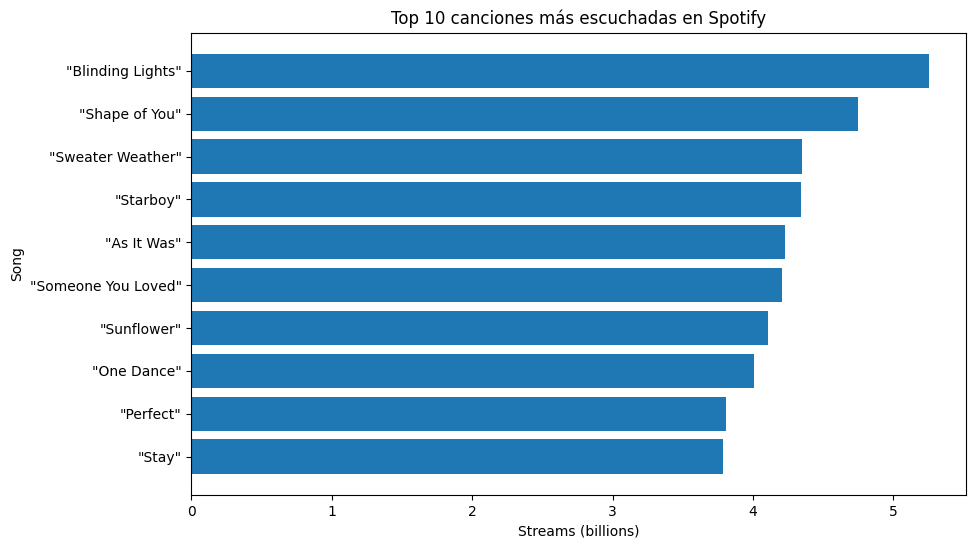

In [47]:
import matplotlib.pyplot as plt


top_songs = df.sort_values(
    by='Streams (billions)',
    ascending=False
).head(10)

plt.figure(figsize=(10,6))
plt.barh(top_songs['Song'], top_songs['Streams (billions)'])
plt.xlabel('Streams (billions)')
plt.ylabel('Song')
plt.title('Top 10 canciones más escuchadas en Spotify')
plt.gca().invert_yaxis()
plt.show()

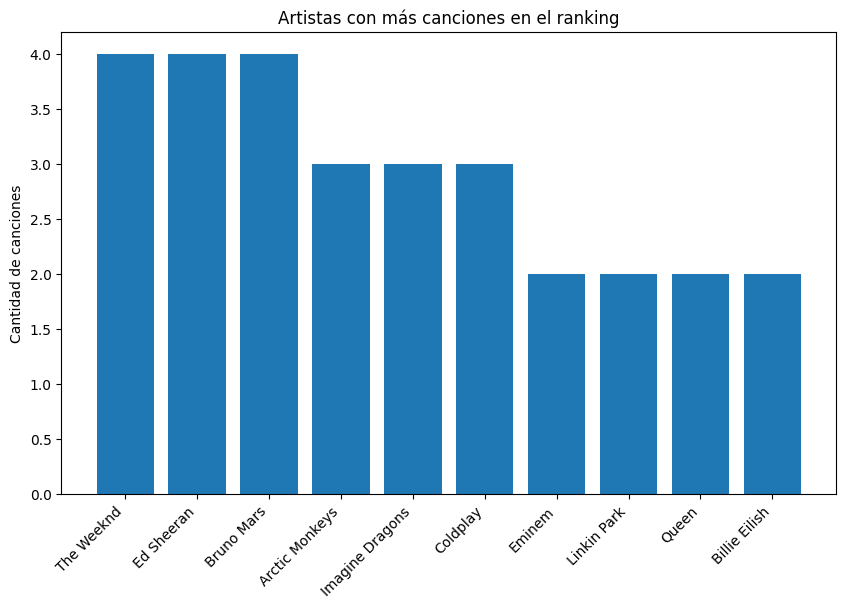

In [49]:
artist_count = df['Artist(s)'].value_counts().head(10)
plt.figure(figsize=(10,6))
plt.bar(artist_count.index, artist_count.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cantidad de canciones')
plt.title('Artistas con más canciones en el ranking')
plt.show()

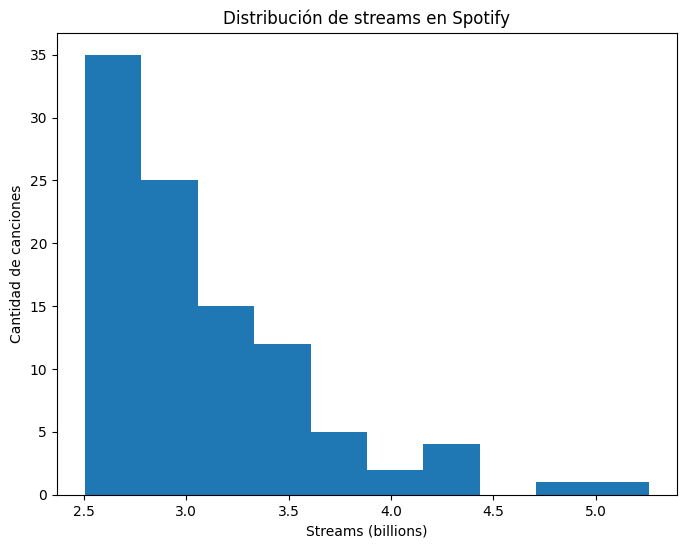

In [50]:
plt.figure(figsize=(8,6))
plt.hist(df['Streams (billions)'], bins=10)
plt.xlabel('Streams (billions)')
plt.ylabel('Cantidad de canciones')
plt.title('Distribución de streams en Spotify')
plt.show()